# 한화 이글스 새로운 투수 Yefry Ramirez의 데이터 분석

# 1. 패키지 import

In [32]:
import sys
sys.path.append("D:\\library")

import pandas as pd
import decimal
ctx = decimal.getcontext()
ctx.rounding = decimal.ROUND_UP
from statistics import mean

from IPython.display import display, HTML
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from baseball_library.kbo.DBControler import connect_db
conn, engine = connect_db()

# 2. 선수 데이터 불러오기

In [2]:
player_id=606162
game_year=2022

aaa_total_pbp_df = pd.read_sql("""select * from mlb.pbp where league='aaa' and game_year={} and event_type='pitch'""".format(game_year), engine)
aaa_total_boxscore_batter_df = pd.read_sql(""" select * from mlb.batter_boxscore as mbb
                                            left join mlb.games as mg on mbb.game_pk=mg.game_pk
                                            where mg.game_year={} and mbb.level='aaa'
                                            """.format(game_year), engine)

## 2.1. 구종정보

### 1) 리그 우투수 평균

In [3]:
player_pitch_type_list = list(aaa_total_pbp_df[aaa_total_pbp_df.pitcher_id==player_id]['pitch_type'].dropna().unique())

league_pitch_type_list = list(aaa_total_pbp_df['pitch_type'].dropna().unique())
league_tracking_df = pd.DataFrame(columns=['pitch_type', 'np', 'percent', 'avg_speed', 'avg_vertical_break', 'avg_horizontal_break', 'avg_spin_rate', 'extension'])

total_count = aaa_total_pbp_df[aaa_total_pbp_df['rel_speed'].isnull()==False].shape[0]

for seq, pitch_type in enumerate(player_pitch_type_list):

    pitch_type_df = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) & (aaa_total_pbp_df['rel_speed'].isnull()==False) & (aaa_total_pbp_df['throws']=='R')]

    avg_speed = round(pitch_type_df['rel_speed'].mean()*1.609344,1)
    avg_horizontal_break = round(pitch_type_df['pfx_x'].mean()*-2.54,1)
    avg_vertical_break = round(pitch_type_df['pfx_z'].mean()*2.54,1)
    avg_spin_rate = int(pitch_type_df['spin_rate'].mean())
    avg_extension = round(pitch_type_df['extension'].mean()*0.3048,2)

    percent = round((pitch_type_df.shape[0]*100)/total_count,2)

    league_tracking_df.loc[len(league_tracking_df)] = [pitch_type, pitch_type_df.shape[0],percent,  avg_speed, avg_vertical_break, avg_horizontal_break, avg_spin_rate, avg_extension]

league_tracking_df.sort_values(['percent'], ascending=[False], inplace=True)
league_tracking_df

,pitch_type,np,percent,avg_speed,avg_vertical_break,avg_horizontal_break,avg_spin_rate,extension
0,FF,20010,24.66,149.5,22.7,10.4,2253,1.95
1,SL,12607,15.54,133.6,2.6,-7.2,2370,1.90
3,SI,8514,10.49,148.3,13.1,21.8,2119,1.90
4,CH,6816,8.40,135.1,9.2,18.5,1775,1.93
2,CU,5726,7.06,125.3,-12.3,-9.7,2375,1.91


In [39]:
league_sz_top = aaa_total_pbp_df['sz_top'].mean()
league_sz_bot = aaa_total_pbp_df['sz_bot'].mean()
league_pitch_type_df = pd.DataFrame(columns=['pitch_type', 'first_in_zone', 'first_in_zone%', 'pitches', 'swing', 'swing%', 'contact', 'contact%', 'ev'])

for pitch_seq, pitch_type in enumerate(player_pitch_type_list):
    pitch_type_df = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type)]

    first_pitches = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) & (aaa_total_pbp_df['pitch_num']==1)]
    first_in_zone= aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) & \
                                    (
                                        ((aaa_total_pbp_df['px']>=-0.70835) & (aaa_total_pbp_df['px']<=0.70835))&
                                        ((aaa_total_pbp_df['pz']>=league_sz_bot) & (aaa_total_pbp_df['pz']<=league_sz_top))
                                    )&\
                                    (aaa_total_pbp_df['pitch_num']==1)
                                    ]
    first_in_zone_percent = round((first_in_zone.shape[0]*100)/first_pitches.shape[0],2)

    swing_pitches = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) &
                                    ((aaa_total_pbp_df['description']=='swinging_strike')|
                                    (aaa_total_pbp_df['description']=='in_play_out')|
                                    (aaa_total_pbp_df['description']=='in_play_no_out')|
                                    (aaa_total_pbp_df['description']=='foul_tip')|
                                    (aaa_total_pbp_df['description']=='foul')|
                                    (aaa_total_pbp_df['description']=='in_play_run')|
                                    (aaa_total_pbp_df['description']=='swinging_strike_blocked')|
                                    (aaa_total_pbp_df['description']=='foul_bunt'))]

    swing_percent = round((swing_pitches.shape[0]*100)/pitch_type_df.shape[0],2)
    
    miss_pitches = swing_pitches[(swing_pitches['pitch_type']==pitch_type) &
                                ((swing_pitches.description=='swinging_strike')|
                                (swing_pitches.description=='swinging_strike_blocked')|
                                (swing_pitches.description=='miss_bunt'))]
    
    try:
        miss_percent = round((miss_pitches.shape[0]*100)/swing_pitches.shape[0],2)
    except:
        miss_percent = 0
    
    ev = mean(list(aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type)]['exit_speed'].dropna()))*1.609344
    
    league_pitch_type_df.loc[len(league_pitch_type_df)] = [pitch_type, first_in_zone.shape[0], first_in_zone_percent, pitch_type_df.shape[0], swing_pitches.shape[0], swing_percent, swing_pitches.shape[0]-miss_pitches.shape[0], 100-miss_percent, ev]

display(league_pitch_type_df)

,pitch_type,first_in_zone,first_in_zone%,pitches,swing,swing%,contact,contact%,ev
0,FF,3271,43.77,28163,13039,46.30,10426,79.96,143.817261
1,SL,1626,39.25,18008,8278,45.97,5394,65.16,137.308715
2,CU,866,37.26,7674,2905,37.86,2008,69.12,138.251096
3,SI,1414,42.63,11077,4912,44.34,4122,83.92,141.628651
4,CH,771,37.78,10911,5343,48.97,3694,69.14,139.177342


### 2) 선수

#### (1). 전체적인 수치

In [27]:
player_pitch_type_list = list(aaa_total_pbp_df[aaa_total_pbp_df.pitcher_id==player_id]['pitch_type'].dropna().unique())
pitcher_tracking_df = pd.DataFrame(columns=['pitch_type', 'np', 'percent',  'avg_speed', 'max_speed', 'avg_vertical_break', 'avg_horizontal_break', 'avg_spin_rate', 'extension'])
player_df = aaa_total_pbp_df[(aaa_total_pbp_df['pitcher_id']==player_id)]
player_pitch_count = aaa_total_pbp_df[aaa_total_pbp_df.pitcher_id==player_id].shape[0]

for pitch_type in player_pitch_type_list:

    pitch_type_df = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) & (aaa_total_pbp_df['pitcher_id']==player_id)]
    avg_speed = round(pitch_type_df['rel_speed'].mean()*1.609344,1)
    max_speed = round(pitch_type_df['rel_speed'].max()*1.609344,1)
    avg_horizontal_break = round(pitch_type_df['pfx_x'].mean()*-2.54,1)
    avg_vertical_break = round(pitch_type_df['pfx_z'].mean()*2.54,1)
    avg_spin_rate = int(pitch_type_df['spin_rate'].mean())
    avg_extension = round(pitch_type_df['extension'].mean()*0.3048,2)

    percent = round((pitch_type_df.shape[0]*100)/player_pitch_count,2)

    pitcher_tracking_df.loc[len(pitcher_tracking_df)] = [pitch_type, pitch_type_df.shape[0], percent, avg_speed, max_speed, avg_vertical_break, avg_horizontal_break, avg_spin_rate, avg_extension]

pitcher_tracking_df.sort_values(['percent'], ascending=[False], inplace=True)
pitcher_tracking_df

,pitch_type,np,percent,avg_speed,max_speed,avg_vertical_break,avg_horizontal_break,avg_spin_rate,extension
1,SL,158,24.73,138.8,143.9,8.9,-4.6,2314,1.95
0,FF,154,24.10,149.1,152.2,22.6,10.5,2348,1.95
3,SI,152,23.79,147.0,151.3,21.3,19.1,2240,1.95
4,CH,120,18.78,138.9,145.2,14.2,18.0,1927,1.96
2,CU,52,8.14,126.5,138.1,-2.8,-8.0,2445,1.93


In [41]:
player_sz_top = player_df['sz_top'].mean()
player_sz_bot = player_df['sz_bot'].mean()
player_pitch_type_df = pd.DataFrame(columns=['pitch_type', 'first_in_zone', 'first_in_zone%', 'pitches', 'swing', 'swing%', 'contact', 'contact%', 'ev'])

for pitch_seq, pitch_type in enumerate(player_pitch_type_list):
    pitch_type_df = player_df[(player_df['pitch_type']==pitch_type)]

    first_pitches = player_df[(player_df['pitch_type']==pitch_type) & (player_df['pitch_num']==1)]
    first_in_zone= player_df[(player_df['pitch_type']==pitch_type) & \
                                    (
                                        ((player_df['px']>=-0.70835) & (player_df['px']<=0.70835))&
                                        ((player_df['pz']>=player_sz_bot) & (player_df['pz']<=player_sz_top))
                                    )&\
                                    (player_df['pitch_num']==1)
                                    ]
    first_in_zone_percent = round((first_in_zone.shape[0]*100)/first_pitches.shape[0],2)

    swing_pitches = player_df[(player_df['pitch_type']==pitch_type) &
                                    ((player_df['description']=='swinging_strike')|
                                    (player_df['description']=='in_play_out')|
                                    (player_df['description']=='in_play_no_out')|
                                    (player_df['description']=='foul_tip')|
                                    (player_df['description']=='foul')|
                                    (player_df['description']=='in_play_run')|
                                    (player_df['description']=='swinging_strike_blocked')|
                                    (player_df['description']=='foul_bunt'))]

    swing_percent = round((swing_pitches.shape[0]*100)/pitch_type_df.shape[0],2)
    
    miss_pitches = swing_pitches[(swing_pitches['pitch_type']==pitch_type) &
                                ((swing_pitches.description=='swinging_strike')|
                                (swing_pitches.description=='swinging_strike_blocked')|
                                (swing_pitches.description=='miss_bunt'))]
    
    try:
        miss_percent = round((miss_pitches.shape[0]*100)/swing_pitches.shape[0],2)
    except:
        miss_percent = 0

    ev = mean(list(player_df[(player_df['pitch_type']==pitch_type)]['exit_speed'].dropna()))*1.609344
    
    player_pitch_type_df.loc[len(player_pitch_type_df)] = [pitch_type, first_in_zone.shape[0], first_in_zone_percent, pitch_type_df.shape[0], swing_pitches.shape[0], swing_percent, swing_pitches.shape[0]-miss_pitches.shape[0], 100-miss_percent, ev]

display(player_pitch_type_df)

,pitch_type,first_in_zone,first_in_zone%,pitches,swing,swing%,contact,contact%,ev
0,FF,15,38.46,154,81,52.60,72,88.89,141.926259
1,SL,13,36.11,158,70,44.30,40,57.14,146.902453
2,CU,9,36.00,52,20,38.46,16,80.00,143.304768
3,SI,15,35.71,152,82,53.95,65,79.27,134.331944
4,CH,9,40.91,120,61,50.83,44,72.13,139.346200


#### (2) 무브먼트

(-40.0, 40.0)

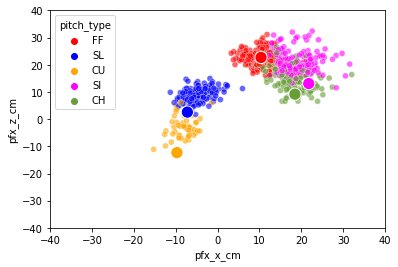

In [5]:
player_df['pfx_x_cm'] = player_df['pfx_x']*-2.54
player_df['pfx_z_cm'] = player_df['pfx_z']*2.54

color_dict = {

    "FF":'red',
    "SI":'#ff00ff',
    "SL":'blue',
    "CH":'#679e35',
    "CU":'orange'

}

ax = sns.scatterplot(x='pfx_x_cm', y='pfx_z_cm', hue='pitch_type', palette=color_dict, data=player_df, alpha=0.6)
sns.scatterplot(x='avg_horizontal_break', y='avg_vertical_break', data=league_tracking_df, hue='pitch_type', legend=False, s=150, ax=ax, palette=color_dict)
ax.set_xlim([-40,40])
ax.set_ylim([-40,40])

#### (3). 좌/우 타자에 따른 구종구사율

In [42]:
for seq, stands in enumerate(['R', 'L']):
    total_count = aaa_total_pbp_df[(aaa_total_pbp_df['rel_speed'].isnull()==False) & (aaa_total_pbp_df['stands']==stands) & (aaa_total_pbp_df['pitcher_id']==player_id)].shape[0]
    stand_pitcher_tracking_df = pd.DataFrame(columns=['pitch_type', 'np', 'percent', 'swing%', 'contact%'])
    for pitch_type in player_pitch_type_list:
        pitch_type_df = aaa_total_pbp_df[(aaa_total_pbp_df['pitch_type']==pitch_type) & (aaa_total_pbp_df['pitcher_id']==player_id) & (aaa_total_pbp_df['stands']==stands)]
        avg_speed = round(pitch_type_df['rel_speed'].mean()*1.609344,1)

        try:
            percent = round((pitch_type_df.shape[0]*100)/total_count,2)
        except:
            percent = 0

        swing_pitches = pitch_type_df[(pitch_type_df['pitch_type']==pitch_type) &
                                        ((pitch_type_df['description']=='swinging_strike')|
                                        (pitch_type_df['description']=='in_play_out')|
                                        (pitch_type_df['description']=='in_play_no_out')|
                                        (pitch_type_df['description']=='foul_tip')|
                                        (pitch_type_df['description']=='foul')|
                                        (pitch_type_df['description']=='in_play_run')|
                                        (pitch_type_df['description']=='swinging_strike_blocked')|
                                        (pitch_type_df['description']=='foul_bunt'))]

        swing_percent = round((swing_pitches.shape[0]*100)/pitch_type_df.shape[0],2)
        
        miss_pitches = swing_pitches[(swing_pitches['pitch_type']==pitch_type) &
                                    ((swing_pitches.description=='swinging_strike')|
                                    (swing_pitches.description=='swinging_strike_blocked')|
                                    (swing_pitches.description=='miss_bunt'))]
        
        try:
            miss_percent = round((miss_pitches.shape[0]*100)/swing_pitches.shape[0],2)
        except:
            miss_percent = 0

        stand_pitcher_tracking_df.loc[len(stand_pitcher_tracking_df)] = [pitch_type, pitch_type_df.shape[0], percent, swing_percent, 100-miss_percent]

    stand_pitcher_tracking_df.sort_values(['percent'], ascending=[False], inplace=True)
    print("{}. {}타자 상대 구사율".format(seq+1,"좌" if stands=='L' else "우")) 
    display(stand_pitcher_tracking_df)

1. 우타자 상대 구사율


,pitch_type,np,percent,swing%,contact%
1,SL,132,31.65,43.18,52.63
3,SI,109,26.14,56.88,82.26
0,FF,101,24.22,56.44,87.72
4,CH,51,12.23,45.10,69.57
2,CU,24,5.76,37.50,77.78


2. 좌타자 상대 구사율


,pitch_type,np,percent,swing%,contact%
4,CH,69,31.51,55.07,73.68
0,FF,53,24.20,45.28,91.67
3,SI,43,19.63,46.51,70.00
2,CU,28,12.79,39.29,81.82
1,SL,26,11.87,50.00,76.92


#### (4) 로케이션

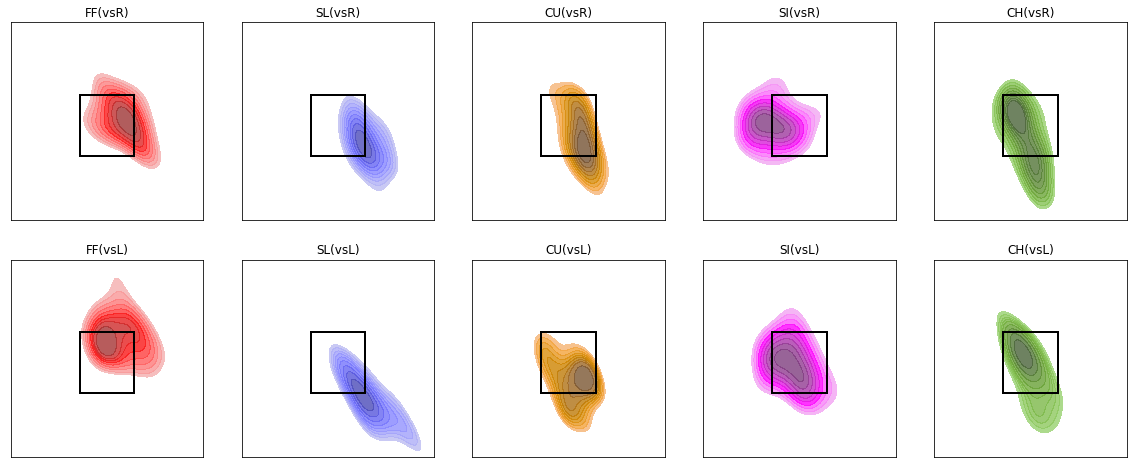

In [45]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, len(player_pitch_type_list),figsize=(20,8), sharex=True, sharey=True)
sz_top = player_df['sz_top'].mean()
sz_bot = player_df['sz_bot'].mean()

for seq, stands in enumerate(['R', 'L']):
    for pitch_seq, pitch_type in enumerate(player_pitch_type_list):
        pitch_type_df = player_df[(player_df['pitch_type']==pitch_type) & (player_df['stands']==stands)]
        
        sns.kdeplot(x='px', y='pz', fill=True, alpha=.8, thresh=.5, data=pitch_type_df, ax=axes[seq, pitch_seq], color=color_dict[pitch_type])
        # sns.scatterplot(x='px', y='pz', data=pitch_type_df, ax=axes[seq, pitch_seq], color=color_dict[pitch_type])
        axes[seq, pitch_seq].plot([0.70835,0.70835], [sz_bot,sz_top], linewidth=2, color='black')
        axes[seq, pitch_seq].plot([-0.70835,0.70835], [sz_top,sz_top], linewidth=2, color='black')
        axes[seq, pitch_seq].plot([-0.70835,-0.70835], [sz_top,sz_bot], linewidth=2, color='black')
        axes[seq, pitch_seq].plot([-0.70835,0.70835], [sz_bot,sz_bot], linewidth=2, color='black')

        axes[seq, pitch_seq].set_xlim([-2.5,2.5])
        axes[seq, pitch_seq].set_ylim([0,5])
        axes[seq, pitch_seq].get_yaxis().set_visible(False)
        axes[seq, pitch_seq].get_xaxis().set_visible(False)

        axes[seq, pitch_seq].set_title("{}(vs{})".format(pitch_type, stands))